#  Lab Instruction

In this notebook, we will learn how to implement Policy Gradient (PG) using Tensorflow.  We will look at a specific version -- Actor Critic Policy Gradient. The notebook contains all the info that you need to understand the basic mechanism of PG, you could also refer to the PG pdf for detailed pseudocode. **Your task** is to fill in the

YOUR CODE HERE

sections in the code blocks below, to complete the building of computation graph, and the implementation of other parts of PG. You are free to tweak all codes except the last block. Your are also free to tweak the hyper-parameters to improve the performance of the agent. The final block of the code evaluates the performance of the agent on an independent 100 episodes on the environment and print out the average testing performance.

Make sure that your final submission is a notebook that can be run from beginning to end, and you should print out the accuracy at the end of the notebook (i.e. be sure to run the last block after training). The upper bound of your agent's performance is 500 (you could get at most 500 for this environment). **Your grade will depend on the final evaluation performance of the agent**. However, if you tweak the code to report false result, you will receive no credit for this assignment.

In [1]:
!pip install tensorflow==1.15.0

In [2]:
import tensorflow as tf
print(tf.__version__)
from collections import deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import gym

1.15.0


In this assignment, we aim to solve CartPole-v1, a slightly more difficult versio than CartPole-v0. More specifically, CartPole-v0 is solved if the pole can be balanced for 200 steps while CartPole-v1 is for 500 steps. The state/action space for both environments are the same. Look at their dimensions as follows:

In [3]:
env = gym.make('CartPole-v1')
print(env.observation_space)  # four observations: horizontal coordinate of car, horizontal velocity of car
                              # angle of the pole to the vertical line, angular velocity of the pole
print(env.action_space)  # two actions: push to the right/left

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Discrete(2)


## Policy Gradient

In the previous lab, we talked about value based method for reinforcement learning. In this lab, we focus on policy based method.

In policy based methods, intead of defining a value function $Q_\theta(s,a)$ and inducing a policy based on argmax, we parameterize a stochastic policy directly. The policy is parameterized as a categorical distribution over actions. Let it be $\pi_\phi(s)$ with parameter $\phi$, then the policy is defined by sampling actions $$a \sim \pi_\phi(s)$$

The policy induces a probability $p(\tau)$ over trajectories $\tau = \{s_0,a_0,s_1,a_1...s_T,a_T\}$ (assume horizon $T$). The expected distribution is 

$$R = \mathbb{E}_{\tau \sim p(\tau)} \big[R(\tau)\big] = \mathbb{E}_\pi \big[\sum_{t=0}^\infty r_t \gamma^t \big]$$

The aim is to find $\phi$ such that the expected reward induced by $\pi_\phi$ is maximized.

### Policy Gradient Computation

We can derive policy gradient

$$\nabla_\phi R = \mathbb{E}_{\pi} \big[\sum_{t=0}^\infty Q^\pi(s_t,a_t) \nabla_\phi \log \pi_\phi(a_t|s_t) \big]$$

To compute the gradient for update $\phi \leftarrow \phi + \alpha \nabla_\phi R$, we need to estimate $Q^\pi(s,a)$. Since $Q^\pi(s,a)$ is usually not analytically accessible, it can be approximated by 
1. Monte Carlo estimate
2. Train a value function $Q_\theta(s,a) \approx Q^\pi(s,a)$ and use it as a proxy
3. Mixture of both above

Before estimating $Q^\pi(s,a)$, let us write a parameterized policy over actions. The policy $\pi_\phi(s)$ takes a state as input and outputs a categorical distribution over actions. For example, if we have two actions, the probability vector to output is of the form $[0.6,0.4]$. 

**Loss function**
The loss function enables us to compute policy gradients in implementation. PG has the form 

$$\frac{1}{N} \sum_{i=1}^N \nabla_\phi \log \pi_\phi(a_i|s_i) Q_i$$

where $Q_i$s are estimated and $\nabla_\phi \log\pi_\phi(a_i|s_i)$s are computed via backprop.

In [4]:
# define neural net \pi_\phi(s) as a class
class Policy(object):
    def __init__(self, obssize, actsize, sess, optimizer):
        """
        obssize: size of the states
        actsize: size of the actions
        """
        # YOUR CODE HERE
        # BUILD PREDICTION GRAPH
        # build the input
        state = tf.placeholder(tf.float32, [None, obssize])
        
        hidden = 128
        # prob = None  # prob is of shape [None, actsize]
        self.W1 = tf.Variable(tf.truncated_normal([obssize, hidden]), name='W1')*0.1
        self.b1 = tf.Variable(tf.zeros([hidden]), name='b1')
        self.h1 = tf.matmul(state, self.W1)+self.b1
        self.W2 = tf.Variable(tf.truncated_normal([hidden, actsize]), name='W2')*0.1
        self.b2 = tf.Variable(tf.zeros([actsize]), name='b2')
        self.h2 = tf.matmul(self.h1, self.W2) + self.b2
        prob = tf.nn.softmax(self.h2)

        # BUILD LOSS 
        Q_estimate = tf.placeholder(tf.float32, [None])
        actions = tf.placeholder(tf.int32, [None])

        # surrogate_loss = None
        surrogate_loss = -tf.reduce_mean(tf.math.log(tf.reduce_sum(prob*tf.one_hot(actions, actsize), axis=1))*Q_estimate)
        
        self.train_op = optimizer.minimize(surrogate_loss)
        
        # some bookkeeping
        self.state = state
        self.prob = prob
        self.actions = actions
        self.Q_estimate = Q_estimate
        self.loss = surrogate_loss
        self.optimizer = optimizer
        self.sess = sess
    
    def compute_prob(self, states):
        """
        compute prob over actions given states pi(a|s)
        states: numpy array of size [numsamples, obssize]
        return: numpy array of size [numsamples, actsize]
        """
        # YOUR CODE HERE
        return self.sess.run(self.prob, feed_dict={self.state: states})

    def train(self, states, actions, Qs):
        """
        states: numpy array (states)
        actions: numpy array (actions)
        Qs: numpy array (Q values)
        """
        return self.sess.run(self.train_op, feed_dict={self.state: states, self.actions: actions, self.Q_estimate: Qs})   

Try to rollout trajecories using the policy

In [5]:
# just pseudocode
"""
env = gym.make("CartPole-v1")
obs = env.reset()
done = False

while not done:
    prob = policy.compute_prob(obs)
    action = np.random.randint(0, prob.size, p=prob.flatten())
    obs, reward, done, info = env.step(action)
"""
"""
obssize = 4
actsize = 2
sess = tf.Session()

optimizer = tf.train.AdamOptimizer()

env = gym.make("CartPole-v1")

policy = Policy(obssize, actsize, sess, optimizer)
sess.run(tf.global_variables_initializer())

obs = env.reset()
done = False    
sum_reward = 0
while not done:
    obs = np.expand_dims(obs, 0)
    prob = policy.compute_prob(obs)
    action = np.random.choice(prob.size, p=prob.flatten())
    obs, reward, done, info = env.step(action)
    sum_reward += reward
print(sum_reward)
"""

'\nobssize = 4\nactsize = 2\nsess = tf.Session()\n\noptimizer = tf.train.AdamOptimizer()\n\nenv = gym.make("CartPole-v1")\n\npolicy = Policy(obssize, actsize, sess, optimizer)\nsess.run(tf.global_variables_initializer())\n\nobs = env.reset()\ndone = False    \nsum_reward = 0\nwhile not done:\n    obs = np.expand_dims(obs, 0)\n    prob = policy.compute_prob(obs)\n    action = np.random.choice(prob.size, p=prob.flatten())\n    obs, reward, done, info = env.step(action)\n    sum_reward += reward\nprint(sum_reward)\n'

### Estimate $Q^\pi(s,a)$

To estimate $Q^\pi(s,a)$, we can rollout the policy until the episode ends and do monte carlo estimate. In particular, under policy $\pi$, we start from state action $(s_0,a_0)$ and rollout the policy to generate a trajectory $\{s_0,a_0,s_1,a_1...s_T,a_T\}$, with corresponding reward $r_0,r_1...r_T$. Monte carlo estimate is 

$$\hat{Q}_{MC}(s,a) = \sum_{t=0}^T r_t \gamma^t \approx Q^\pi(s,a)$$

This estimate by itself is of high variance. Using pure monte carlo estimate may work but the gradient can have large variance and hence take the algorithm  a long time to converge. We can reduce variance using baseline. Recall the derivation of PG

$$\nabla_\phi R = \mathbb{E}_{\pi} \big[\sum_{t=0}^\infty Q^\pi(s_t,a_t) \nabla_\phi \log \pi_\phi(a_t|s_t) \big] = \mathbb{E}_{\pi} \big[\sum_{t=0}^\infty ( Q^\pi(s_t,a_t) - f(s_t)) \nabla_\phi \log \pi_\phi(a_t|s_t) \big]$$

where $f(s_t)$ can be any function of state $s_t$. $f(s_t)$ is called baseline. Optimal baseline function is hard to compute, but a good proxy is the value function $V^\pi(s_t)$. Hence the gradient has the form 
$$\nabla_\phi R = \mathbb{E}_{\pi} \big[\sum_{t=0}^\infty A^\pi(s_t,a_t) \nabla_\phi \log \pi_\phi(a_t|s_t) \big]$$

where $A^\pi(s,a)$ is the advantage. Hence we can train a value function $V^\pi(s)$ along side the policy and use it as baseline to reduce the variance of PG. This paradigm is **actor-critic** method. 

### Train Value Function as Baseline

Hence we also parameterize a value function $V_\theta(s) \approx V^\pi(s)$ with parameter $\theta$ to serve as baseline. The function takes as input the states $s$ and outputs a real value. 

Notice that unlike DQN, where $Q_\theta(s,a) \approx Q^\ast(s,a)$ the approximated target is fixed, now we have $V_\theta(s) \approx V^\pi(s)$ a moving object defined by policyb $\pi$. If $\pi$ is updated by PG, $\pi$ keeps changing, which $V^\pi(s)$ changes as well. We need to adapt $V_\theta(s)$ online to cater for the change in policy. 

Recall that to evaluate a policy $\pi$, we collect rollouts using $\pi$. If we start with state $s_0$, the reward following $\pi$ thereafter is $r_0,r_1...r_{T-1}$  then 

$$V^\pi(s_0) \approx \sum_{t=0}^T r_t \gamma^t = \hat{V}(s_0)$$

We compute $V_\phi(s) \approx V^\pi(s)$ by minimizing 

$$(V_\phi(s_0) - \hat{V}(s_0))^2$$

Hence, given a policy $\pi$. Starting from $s_0$, generate trajectory $\{s_0,a_0,s_1,a_1...a_{T-1},s_T\}$ and rewards $\{r_0,r_1...r_{T-1}\}$. We can estimate the value function for state $s_i,0\leq i\leq T$. In general

$$\hat{V}(s_i) = \sum_{i=t}^T r_i \gamma^{i-t}$$

And the objective to minimize over is 
$$\frac{1}{T+1} \sum_{i=0}^{T} (V_\theta(s_i) - \hat{V}(s_i))^2$$

Since the policy keeps updating, we do not have to minimize the above objective to optimality. In practice, take one gradient step w.r.t. above objective suffices.

In [6]:
# define value function as a class
class ValueFunction(object):
    def __init__(self, obssize, sess, optimizer):
        """
        obssize: size of states
        """
        # YOUR CODE HERE
        # need to implement both prediction and loss
        # pass
        hidden=128
        state = tf.placeholder(tf.float32, [None, obssize])
        self.W1 = tf.Variable(tf.truncated_normal([obssize, hidden]), name='Value_W1')*0.1
        self.b1 = tf.Variable(tf.zeros([hidden]), name='Value_b1')
        self.h1 = tf.nn.relu(tf.matmul(state, self.W1)+self.b1)
        self.W2 = tf.Variable(tf.truncated_normal([hidden, 1]), name='Value_W2')*0.1
        self.b2 = tf.Variable(tf.zeros([1]), name='Value_b2')
        value = tf.matmul(self.h1, self.W2) + self.b2

        target = tf.placeholder(tf.float32, [None])
        loss = tf.reduce_mean(tf.square(value-target))

        self.train_op = optimizer.minimize(loss)

        self.obssize = obssize
        self.sess = sess
        self.optimizer = optimizer
        self.state = state
        self.value = value
        self.target = target
        self.loss = loss

    def compute_values(self, states):
        """
        compute value function for given states
        states: numpy array of size [numsamples, obssize]
        return: numpy array of size [numsamples]
        """
        # YOUR CODE HERE
        # return None
        return self.sess.run(self.value, feed_dict={self.state: states})

    def train(self, states, targets):
        """
        states: numpy array
        targets: numpy array
        """
        # YOUR CODE HERE
        # pass
        return self.sess.run([self.loss, self.train_op], feed_dict={self.state: states, self.target: targets})

In [7]:
# obssize = 4
# actsize = 2
# sess = tf.Session()

# optimizer = tf.train.AdamOptimizer()

# env = gym.make("CartPole-v1")

# value = ValueFunction(obssize, sess, optimizer)
# sess.run(tf.global_variables_initializer())

# obs = env.reset()
# done = False    
# obs = np.expand_dims(obs, 0)

# value.compute_values(obs)
# value.train(obs, np.array([[1.]]))

### Summary of pseudocode (training procedure)

The critical components of the pseudocode is as follows.

**Collect trajectories** Given current policy $\pi_\phi$, we can rollout using the policy by executing $a_t \sim \pi_\phi(s_t)$. Assume that the horizon is $T$, we can collect $N$ trajectories each with length $T+1$.

**Update value function** Value function update is based on minimizing the L2 loss between predicted value function and estimated value functions. For each state in the collected sample $s_i$, estimate a value function using the rest of the path (as above). Let the estimate be $\hat{V}(s_i)$. Then take one gradient step to update $\theta$ using the loss

$$\frac{1}{N(T+1)} \sum_{i=1} (V_\theta(s_i) - \hat{V}(s_i))^2$$

**Update policy using PG** To compute PG, we need to first monte carlo estimate action-value function $\hat{Q}(s_i,a_i)$. Then use value function as a baseline to compute advantage

$$\hat{A}(s_i,a_i) = \hat{Q}(s_i,a_i) - V_\theta(s_i)$$

Then compute surrogate loss 

$$L = - \frac{1}{N(T+1)}\sum_{i} \hat{A}(s_i,a_i) \log \pi(a_i|s_i) $$

The policy is updated by $$\phi \leftarrow \phi - \alpha  \nabla_\phi L$$

## Main iteration implementations

Below are skeleton codes that you may find useful in implementing the above procedure.

In [8]:
# function to calculate the value function
def discounted_rewards(r, gamma):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_sum = 0
    for i in reversed(range(0,len(r))):
        discounted_r[i] = running_sum * gamma + r[i]
        running_sum = discounted_r[i]
    return list(discounted_r)

In [9]:
# YOUR CODE HERE -- feel free to tune/add hyper-parameters
# parameter initializations
alpha = 1e-2  # learning rate for PG
beta = 1e-2  # learning rate for baseline
numtrajs = 1 # num of trajecories to collect at each iteration 
iterations = 5000  # total num of iterations
envname = "CartPole-v1"  # environment name
gamma = .99  # discount
# episodes = 1000


# initialize environment
env = gym.make(envname)
obssize = env.observation_space.low.size
actsize = env.action_space.n

# sess
sess = tf.Session()

# optimizer
optimizer_p = tf.train.AdamOptimizer(alpha)
optimizer_v = tf.train.AdamOptimizer(beta)

# initialize networks
actor = Policy(obssize, actsize, sess, optimizer_p)  # policy initialization
baseline = ValueFunction(obssize, sess, optimizer_v)  # baseline initialization

# initialize tensorflow graphs
sess.run(tf.global_variables_initializer())

solved = False
running_reward = 0
history = []
# main iteration
# for ite in range(episodes):   
ite = 1 
while not solved and ite < iterations:

    # trajs records for batch update
    OBS = []  # observations
    ACTS = []  # actions
    ADS = []  # advantages (to update policy)
    VAL = []  # value functions (to update baseline)

    episode_reward = []
    for num in range(numtrajs):
        # record for each episode
        obss = []  # observations
        acts = []   # actions
        rews = []  # instant rewards

        obs = env.reset()
        done = False

        # rollout one trajectory
        while not done:
            prob = actor.compute_prob(np.expand_dims(obs, 0))
            action = np.random.choice(actsize, p=prob.flatten(), size=1)
            newobs, reward, done, _ = env.step(action[0])
            
            # record
            obss.append(obs)
            acts.append(action[0])
            rews.append(reward)

            # update
            obs = newobs
        # compute returns from instant rewards
        returns = discounted_rewards(rews, gamma)
        episode_reward.append(np.sum(rews))
        # record for batch update
        VAL += returns
        OBS += obss
        ACTS += acts
        
    # print(np.mean(episode_reward))
    ite += 1
    # update baseline
    VAL = np.array(VAL)
    OBS = np.array(OBS)
    ACTS = np.array(ACTS)
    
    loss, _ = baseline.train(OBS, VAL)  # update only one step
    # update policy
    BAS = baseline.compute_values(OBS)  # compute baseline for variance reduction
    ADS = VAL - np.squeeze(BAS, 1)
    
    actor.train(OBS, ACTS, ADS)  # update only one step

    running_reward = 0.05*np.mean(episode_reward) + (1-0.05)*running_reward
    history.append(running_reward)
    if ite%10 == 0:
        print("iteration "+str(ite)+': ', running_reward)
    if running_reward > 499.9:
        print("solved at iteration {}".format(ite))
        break
    if ite > iterations:
        print("not solved after {} episodes".format(iterations))

iteration 10:  8.979632674816406
iteration 20:  15.541752780842007
iteration 30:  19.499581256488987
iteration 40:  22.694431867254632
iteration 50:  22.198903178801523
iteration 60:  23.86849223520355
iteration 70:  23.033896046930717
iteration 80:  28.728794353536003
iteration 90:  32.134502804360785
iteration 100:  39.1274402134912
iteration 110:  46.61490142987507
iteration 120:  50.73188307315717
iteration 130:  58.31205929791655
iteration 140:  63.856148284047656
iteration 150:  65.13640599054068
iteration 160:  103.824413433712
iteration 170:  142.3328170718884
iteration 180:  176.65032570757955
iteration 190:  183.88476835825267
iteration 200:  185.18760921079777
iteration 210:  243.03962346857892
iteration 220:  303.789658629762
iteration 230:  320.4142784466675
iteration 240:  370.8778947462418
iteration 250:  364.49938515556465
iteration 260:  377.7247328531241
iteration 270:  401.887536053495
iteration 280:  418.2729686967661
iteration 290:  411.9203824244624
iteration 300:

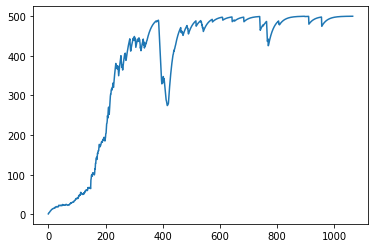

In [10]:
plt.plot(history)

In [14]:
# DO NOT CHANGE CODE HERE
# after training, we will evaluate the performance of the agent
# on a target environment
eval_episodes = 100
record = []
env = gym.make('CartPole-v1')
eval_mode = True
for ite in range(eval_episodes):
    
    obs = env.reset()
    done = False
    rsum = 0
    
    while not done:
        
        # epsilon greedy for exploration
        if eval_mode:
            p = actor.compute_prob(np.expand_dims(obs,0)).ravel()
            action = np.random.choice(np.arange(2), size=1, p=p)[0]
        else:
            raise NotImplementedError

        newobs, r, done, _ = env.step(action)
        rsum += r
        obs = newobs
    
    record.append(rsum)

print("eval performance of PG agent: {}".format(np.mean(record)))

eval performance of PG agent: 500.0
